In [1]:
import json
import pickle
import re
import string
import urllib.request as ur
import warnings
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
from copy import deepcopy
from itertools import product
from operator import itemgetter
from pathlib import Path
import os
from glob import glob
import seaborn as sns
from collections import Counter

warnings.filterwarnings("ignore")

import cv2
import face_recognition
import gensim
import gensim.downloader as api
import googleapiclient.discovery
import joblib
import keras_ocr
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
from tqdm.notebook import tqdm
from gensim.models import Word2Vec
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from scipy.stats import iqr
from skimage import color, exposure, transform
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import load_model
from tinydb import Query, TinyDB
from yolov4.tf import YOLOv4
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import nan_euclidean_distances

from utils import YTDownloader, read_config

def load_pickle(path):
    print("Loading from:", path)
    with open(path, 'rb') as fh:
        return pickle.load(fh)

def save_pickle(obj, path):
    print("Saving to:", path)
    with open(path, 'wb') as fh:
        return pickle.dump(obj, fh)

cache_dir = Path('data/chkp5/cache')
cache_dir.mkdir(exist_ok=True, parents=True)

emotions_to_idx = {'Angry': 0, 'Sad': 5, 'Neutral': 4, 'Disgust': 1, 'Surprise': 6, 'Fear': 2, 'Happy': 3}
idx_to_emotions = {v:k for k,v in emotions_to_idx.items()}

config = read_config("config.json")
config['dataset_path'] = Path(config['dataset_path'])

start_transaction = lambda: TinyDB('data/not_trending_db.json')

In [2]:
wv = api.load('word2vec-google-news-300')
model = load_model('data/model_v6_23.hdf5')
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/hylomorph/.keras-ocr/craft_mlt_25k.h5
Looking for /home/hylomorph/.keras-ocr/crnn_kurapan.h5


## Wybieranie unikalnych ID filmów trending

In [3]:
# df = pd.read_pickle('data/chkp1.pkl')

# with start_transaction() as db:
#     video_ids = set(map(itemgetter('video_id'), db.all()))
#     print("Liczba rekordów:", len(video_ids))

#     inserted = db.insert_multiple({'video_id': idx} for idx in df.index if idx not in video_ids)
#     print("Wstawiono:", len(inserted))

In [4]:
# minDate = df.publish_time.min().isoformat()
# maxDate = df.publish_time.max().isoformat()
# print("Wyszukiwanie danych od:", minDate, "do", maxDate)

## Wczytywanie danych

In [5]:
df = pd.read_json('data/chkp5/data.json') #.head(42)
df.set_index('video_id', inplace=True)
print(df.shape)
df.head(3)

(45208, 17)


publishedAt                 channelId  \
video_id                                                      
Y8Ceu9YBR1I  2019-01-02T14:00:03Z  UCIiBf-JbtCazHSFqXV4JgoA   
St6aYO0Gz5U  2019-02-09T05:35:24Z  UCIRYBXDze5krPDzAEOxFGVA   
k8JuFit-j38  2018-09-06T16:00:13Z  UC1A_Hq-N1dHhAvwg0QWC7Sw   

                                                         title  \
video_id                                                         
Y8Ceu9YBR1I  GRACE N MICHELLE REUNITE AFTER 6 YEARS!!!! // ...   
St6aYO0Gz5U  Matthew Whitaker testifies before House judici...   
k8JuFit-j38         Making Music But Everything Is A Challenge   

                                                   description  \
video_id                                                         
Y8Ceu9YBR1I  Michelle and I reunited AT LAST! And we did a ...   
St6aYO0Gz5U  US acting attorney general Matthew Whitaker te...   
k8JuFit-j38  I take a plugin which generates "random beat m...   

                                                    thumbnails   channelTitle  \
video_id                                                                        
Y8Ceu9YBR1I  {'default': {'url': 'https://i.ytimg.com/vi/Y8...   Grace Helbig   
St6aYO0Gz5U  {'default': {'url': 'https://i.ytimg.com/vi/St...  Guardian News   
k8JuFit-j38  {'default': {'url': 'https://i.ytimg.com/vi/k8...      Levi Niha   

                                                          tags  categoryId  \
video_id                                                                     
Y8Ceu9YBR1I  [grace, helbig, grace helbig, gracehelbig, gra...          22   
St6aYO0Gz5U  [matthew whitaker, whitaker, whitaker testimon...          25   
k8JuFit-j38  [Beat Making, Making A Beat, Music, Music Maki...          10   

            liveBroadcastContent  \
video_id                           
Y8Ceu9YBR1I                 none   
St6aYO0Gz5U                 none   
k8JuFit-j38                 none   

                                                     localized  \
video_id                                                         
Y8Ceu9YBR1I  {'title': 'GRACE N MICHELLE REUNITE AFTER 6 YE...   
St6aYO0Gz5U  {'title': 'Matthew Whitaker testifies before H...   
k8JuFit-j38  {'title': 'Making Music But Everything Is A Ch...   

            defaultAudioLanguage  viewCount  likeCount  dislikeCount  \
video_id                                                               
Y8Ceu9YBR1I                   en   134287.0     9284.0          27.0   
St6aYO0Gz5U                en-GB    31382.0      149.0          30.0   
k8JuFit-j38                  NaN   230180.0     6358.0         122.0   

             favoriteCount  commentCount defaultLanguage  
video_id                                                  
Y8Ceu9YBR1I              0         910.0             NaN  
St6aYO0Gz5U              0          18.0             NaN  
k8JuFit-j38              0         469.0             NaN

#### Ujednolicenie nazw kolumn

In [6]:
df = df[[
    'publishedAt', 'title', 'description',
    'channelTitle', 'categoryId', 'tags',
    'viewCount', 'likeCount', 'dislikeCount',
    'commentCount', 'thumbnails'
]]

df.columns = [
    'publish_time', 'title', 'description',
    'channel_title', 'category_id', 'tags',
    'views', 'likes', 'dislikes',
    'comment_count', 'thumbnails'
]

df.head(3)

publish_time  \
video_id                            
Y8Ceu9YBR1I  2019-01-02T14:00:03Z   
St6aYO0Gz5U  2019-02-09T05:35:24Z   
k8JuFit-j38  2018-09-06T16:00:13Z   

                                                         title  \
video_id                                                         
Y8Ceu9YBR1I  GRACE N MICHELLE REUNITE AFTER 6 YEARS!!!! // ...   
St6aYO0Gz5U  Matthew Whitaker testifies before House judici...   
k8JuFit-j38         Making Music But Everything Is A Challenge   

                                                   description  channel_title  \
video_id                                                                        
Y8Ceu9YBR1I  Michelle and I reunited AT LAST! And we did a ...   Grace Helbig   
St6aYO0Gz5U  US acting attorney general Matthew Whitaker te...  Guardian News   
k8JuFit-j38  I take a plugin which generates "random beat m...      Levi Niha   

             category_id                                               tags  \
video_id                                                                      
Y8Ceu9YBR1I           22  [grace, helbig, grace helbig, gracehelbig, gra...   
St6aYO0Gz5U           25  [matthew whitaker, whitaker, whitaker testimon...   
k8JuFit-j38           10  [Beat Making, Making A Beat, Music, Music Maki...   

                views   likes  dislikes  comment_count  \
video_id                                                 
Y8Ceu9YBR1I  134287.0  9284.0      27.0          910.0   
St6aYO0Gz5U   31382.0   149.0      30.0           18.0   
k8JuFit-j38  230180.0  6358.0     122.0          469.0   

                                                    thumbnails  
video_id                                                        
Y8Ceu9YBR1I  {'default': {'url': 'https://i.ytimg.com/vi/Y8...  
St6aYO0Gz5U  {'default': {'url': 'https://i.ytimg.com/vi/St...  
k8JuFit-j38  {'default': {'url': 'https://i.ytimg.com/vi/k8...

#### Opracowanie miniaturek

In [7]:
def get_tbnl_url(x):
    return x['high']['url']

df['thumbnail_link'] = df['thumbnails'].apply(get_tbnl_url)
df.drop('thumbnails', axis=1, inplace=True)
df.head(3)

publish_time  \
video_id                            
Y8Ceu9YBR1I  2019-01-02T14:00:03Z   
St6aYO0Gz5U  2019-02-09T05:35:24Z   
k8JuFit-j38  2018-09-06T16:00:13Z   

                                                         title  \
video_id                                                         
Y8Ceu9YBR1I  GRACE N MICHELLE REUNITE AFTER 6 YEARS!!!! // ...   
St6aYO0Gz5U  Matthew Whitaker testifies before House judici...   
k8JuFit-j38         Making Music But Everything Is A Challenge   

                                                   description  channel_title  \
video_id                                                                        
Y8Ceu9YBR1I  Michelle and I reunited AT LAST! And we did a ...   Grace Helbig   
St6aYO0Gz5U  US acting attorney general Matthew Whitaker te...  Guardian News   
k8JuFit-j38  I take a plugin which generates "random beat m...      Levi Niha   

             category_id                                               tags  \
video_id                                                                      
Y8Ceu9YBR1I           22  [grace, helbig, grace helbig, gracehelbig, gra...   
St6aYO0Gz5U           25  [matthew whitaker, whitaker, whitaker testimon...   
k8JuFit-j38           10  [Beat Making, Making A Beat, Music, Music Maki...   

                views   likes  dislikes  comment_count  \
video_id                                                 
Y8Ceu9YBR1I  134287.0  9284.0      27.0          910.0   
St6aYO0Gz5U   31382.0   149.0      30.0           18.0   
k8JuFit-j38  230180.0  6358.0     122.0          469.0   

                                               thumbnail_link  
video_id                                                       
Y8Ceu9YBR1I  https://i.ytimg.com/vi/Y8Ceu9YBR1I/hqdefault.jpg  
St6aYO0Gz5U  https://i.ytimg.com/vi/St6aYO0Gz5U/hqdefault.jpg  
k8JuFit-j38  https://i.ytimg.com/vi/k8JuFit-j38/hqdefault.jpg

In [8]:
# df_marcin = pd.read_csv('data/df_marcin.csv').set_index('video_id')
# print(df_marcin.shape)

# df_marcin = df_marcin.loc[list(set(df_marcin[df.columns].index) - set(df.index))]
# print(df_marcin.shape)

In [9]:
# df = pd.concat([df, df_marcin], axis=0)
# print(df.shape)

In [10]:
def handle_dates(df, cols):
    for col in cols:
        df[col+'_day'] = df[col].dt.day
        df[col+'_month'] = df[col].dt.month
        df[col+'_year'] = df[col].dt.year
        df[col+'_weekday'] = df[col].dt.dayofweek
        df[col+'_quarter'] = df[col].dt.quarter
        if col == 'publish_time':
            df[col+'_hour'] = df[col].dt.hour
            df[col+'_minute'] = df[col].dt.minute
            df[col+'_second'] = df[col].dt.second
    return df

df['publish_time'] = pd.to_datetime(df['publish_time'])
df = handle_dates(df, ['publish_time'])
df.drop('publish_time', axis=1, inplace=True)
df.head(3)

title  \
video_id                                                         
Y8Ceu9YBR1I  GRACE N MICHELLE REUNITE AFTER 6 YEARS!!!! // ...   
St6aYO0Gz5U  Matthew Whitaker testifies before House judici...   
k8JuFit-j38         Making Music But Everything Is A Challenge   

                                                   description  channel_title  \
video_id                                                                        
Y8Ceu9YBR1I  Michelle and I reunited AT LAST! And we did a ...   Grace Helbig   
St6aYO0Gz5U  US acting attorney general Matthew Whitaker te...  Guardian News   
k8JuFit-j38  I take a plugin which generates "random beat m...      Levi Niha   

             category_id                                               tags  \
video_id                                                                      
Y8Ceu9YBR1I           22  [grace, helbig, grace helbig, gracehelbig, gra...   
St6aYO0Gz5U           25  [matthew whitaker, whitaker, whitaker testimon...   
k8JuFit-j38           10  [Beat Making, Making A Beat, Music, Music Maki...   

                views   likes  dislikes  comment_count  \
video_id                                                 
Y8Ceu9YBR1I  134287.0  9284.0      27.0          910.0   
St6aYO0Gz5U   31382.0   149.0      30.0           18.0   
k8JuFit-j38  230180.0  6358.0     122.0          469.0   

                                               thumbnail_link  \
video_id                                                        
Y8Ceu9YBR1I  https://i.ytimg.com/vi/Y8Ceu9YBR1I/hqdefault.jpg   
St6aYO0Gz5U  https://i.ytimg.com/vi/St6aYO0Gz5U/hqdefault.jpg   
k8JuFit-j38  https://i.ytimg.com/vi/k8JuFit-j38/hqdefault.jpg   

             publish_time_day  publish_time_month  publish_time_year  \
video_id                                                               
Y8Ceu9YBR1I                 2                   1               2019   
St6aYO0Gz5U                 9                   2               2019   
k8JuFit-j38                 6                   9               2018   

             publish_time_weekday  publish_time_quarter  publish_time_hour  \
video_id                                                                     
Y8Ceu9YBR1I                     2                     1                 14   
St6aYO0Gz5U                     5                     1                  5   
k8JuFit-j38                     3                     3                 16   

             publish_time_minute  publish_time_second  
video_id                                               
Y8Ceu9YBR1I                    0                    3  
St6aYO0Gz5U                   35                   24  
k8JuFit-j38                    0                   13

### Wczytywanie danych trending

In [11]:
df_trending = pd.read_pickle('data/chkp2.pkl')
df_filled = pd.read_pickle('data/chkp12_filled.pkl')

df_trending.drop('category_id', axis=1, inplace=True)
df_trending = df_trending.join(df_filled.category_id)

df_trending['tags'] = df_trending.tags.str.split('|').apply(lambda x: [s.strip('"') for s in x])
df_trending = df_trending[df.columns]
df_trending.head(3)

title  \
video_id                                                         
9wRQljFNDW8  Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...   
Om_zGhJLZ5U     TL;DW - Every DCEU Movie Before Justice League   
goP4Z5wyOlM  Iraq-Iran earthquake: Deadly tremor hits borde...   

                                                   description  \
video_id                                                         
9wRQljFNDW8  New England Patriots returner Dion Lewis blast...   
Om_zGhJLZ5U  With Justice League approaching fast we rewatc...   
goP4Z5wyOlM  A strong 7.2-magnitude earthquake has rattled ...   

              channel_title  category_id  \
video_id                                   
9wRQljFNDW8             NFL         17.0   
Om_zGhJLZ5U  Screen Junkies          1.0   
goP4Z5wyOlM        BBC News         25.0   

                                                          tags   views  likes  \
video_id                                                                        
9wRQljFNDW8  [NFL, Football, offense, defense, afc, nfc, Am...   81377    655   
Om_zGhJLZ5U  [screenjunkies, screen junkies, sj news, hones...  288922   7515   
goP4Z5wyOlM  [bbc, bbc news, news, iran, iran news, iraq, i...   34785    308   

             dislikes  comment_count  \
video_id                               
9wRQljFNDW8        25            177   
Om_zGhJLZ5U       792           2111   
goP4Z5wyOlM        26            413   

                                             thumbnail_link  publish_time_day  \
video_id                                                                        
9wRQljFNDW8  https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg                13   
Om_zGhJLZ5U  https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg                12   
goP4Z5wyOlM  https://i.ytimg.com/vi/goP4Z5wyOlM/default.jpg                12   

             publish_time_month  publish_time_year  publish_time_weekday  \
video_id                                                                   
9wRQljFNDW8                  11               2017                     0   
Om_zGhJLZ5U                  11               2017                     6   
goP4Z5wyOlM                  11               2017                     6   

             publish_time_quarter  publish_time_hour  publish_time_minute  \
video_id                                                                    
9wRQljFNDW8                     4                  2                    5   
Om_zGhJLZ5U                     4                 18                    0   
goP4Z5wyOlM                     4                 21                   16   

             publish_time_second  
video_id                          
9wRQljFNDW8                   26  
Om_zGhJLZ5U                    3  
goP4Z5wyOlM                   40

In [12]:
df['trending'] = 0
df_trending['trending'] = 1

df = pd.concat([df, df_trending], axis=0)
df['category_id'] = df.category_id.astype('int')
df.tags.fillna('[none]', inplace=True)
df.head(3)

title  \
video_id                                                         
Y8Ceu9YBR1I  GRACE N MICHELLE REUNITE AFTER 6 YEARS!!!! // ...   
St6aYO0Gz5U  Matthew Whitaker testifies before House judici...   
k8JuFit-j38         Making Music But Everything Is A Challenge   

                                                   description  channel_title  \
video_id                                                                        
Y8Ceu9YBR1I  Michelle and I reunited AT LAST! And we did a ...   Grace Helbig   
St6aYO0Gz5U  US acting attorney general Matthew Whitaker te...  Guardian News   
k8JuFit-j38  I take a plugin which generates "random beat m...      Levi Niha   

             category_id                                               tags  \
video_id                                                                      
Y8Ceu9YBR1I           22  [grace, helbig, grace helbig, gracehelbig, gra...   
St6aYO0Gz5U           25  [matthew whitaker, whitaker, whitaker testimon...   
k8JuFit-j38           10  [Beat Making, Making A Beat, Music, Music Maki...   

                views   likes  dislikes  comment_count  \
video_id                                                 
Y8Ceu9YBR1I  134287.0  9284.0      27.0          910.0   
St6aYO0Gz5U   31382.0   149.0      30.0           18.0   
k8JuFit-j38  230180.0  6358.0     122.0          469.0   

                                               thumbnail_link  \
video_id                                                        
Y8Ceu9YBR1I  https://i.ytimg.com/vi/Y8Ceu9YBR1I/hqdefault.jpg   
St6aYO0Gz5U  https://i.ytimg.com/vi/St6aYO0Gz5U/hqdefault.jpg   
k8JuFit-j38  https://i.ytimg.com/vi/k8JuFit-j38/hqdefault.jpg   

             publish_time_day  publish_time_month  publish_time_year  \
video_id                                                               
Y8Ceu9YBR1I                 2                   1               2019   
St6aYO0Gz5U                 9                   2               2019   
k8JuFit-j38                 6                   9               2018   

             publish_time_weekday  publish_time_quarter  publish_time_hour  \
video_id                                                                     
Y8Ceu9YBR1I                     2                     1                 14   
St6aYO0Gz5U                     5                     1                  5   
k8JuFit-j38                     3                     3                 16   

             publish_time_minute  publish_time_second  trending  
video_id                                                         
Y8Ceu9YBR1I                    0                    3         0  
St6aYO0Gz5U                   35                   24         0  
k8JuFit-j38                    0                   13         0

# Wyznaczanie cech

In [13]:
text_features = ['title', 'description', 'channel_title']
attention_symbols = '!?$#'

def punctutation_count(text):
    return len([c for c in str(text) if c in string.punctuation])

def attention_count(text):
    return len([c for c in str(text) if c in attention_symbols])

def text_len(text):
    return len(str(text))

def letter_count(text):
    return len(list(filter(str.isalpha, str(text))))

def information_ratio(df):
    for name in text_features:
        df[name+'_information_ratio'] = (df[name+'_letter_count'] / df[name+'_len']).fillna(0)
    return df

def attention_ratio(df):
    for name in text_features:
        df[name+'_attention_ratio'] = (df[name+'_attention_count'] / df[name+'_letter_count']).fillna(0)
    return df

def word_count(df):
    for name in text_features:
        df[name+'_word_count'] = df[name].str.count(r"[\w\-_#\/\\\+\:$?]+")
    return df

def url_count(df):
    df['description_url_count'] = df.description.str.count(r"(https?:\/\/)?(\w+\.\w+)[\?=\&\w_\-.\/.]*")
    return df

def url_ratio(df):
    df['description_url_ratio'] = (df['description_url_count'] / df['description_word_count']).fillna(0)
    return df

def shouting_ratio(text):
    """Returns ratio of upper letters to all letters. Ignores non-letters in summary"""
    if not isinstance(text, str):
        return np.nan
    
    letters = ''.join(filter(str.isalpha, text))
    if letters:
        uppers = ''.join(filter(str.isupper, letters))
        return len(uppers) / len(letters)
    else:
        return 0

df[[n+'_punctuation_count' for n in text_features]] = df[text_features].applymap(punctutation_count)
df[[n+'_attention_count' for n in text_features]] = df[text_features].applymap(attention_count)
df[[n+'_len' for n in text_features]] = df[text_features].applymap(text_len)
df[[n+'_letter_count' for n in text_features]] = df[text_features].applymap(letter_count)
df = information_ratio(df)
df = attention_ratio(df)
df = word_count(df)
df = url_count(df)
df = url_ratio(df)
df[[f'shouting_ratio_{f}' for f in text_features]] = df[text_features].applymap(shouting_ratio)

df.head(3)

title  \
video_id                                                         
Y8Ceu9YBR1I  GRACE N MICHELLE REUNITE AFTER 6 YEARS!!!! // ...   
St6aYO0Gz5U  Matthew Whitaker testifies before House judici...   
k8JuFit-j38         Making Music But Everything Is A Challenge   

                                                   description  channel_title  \
video_id                                                                        
Y8Ceu9YBR1I  Michelle and I reunited AT LAST! And we did a ...   Grace Helbig   
St6aYO0Gz5U  US acting attorney general Matthew Whitaker te...  Guardian News   
k8JuFit-j38  I take a plugin which generates "random beat m...      Levi Niha   

             category_id                                               tags  \
video_id                                                                      
Y8Ceu9YBR1I           22  [grace, helbig, grace helbig, gracehelbig, gra...   
St6aYO0Gz5U           25  [matthew whitaker, whitaker, whitaker testimon...   
k8JuFit-j38           10  [Beat Making, Making A Beat, Music, Music Maki...   

                views   likes  dislikes  comment_count  \
video_id                                                 
Y8Ceu9YBR1I  134287.0  9284.0      27.0          910.0   
St6aYO0Gz5U   31382.0   149.0      30.0           18.0   
k8JuFit-j38  230180.0  6358.0     122.0          469.0   

                                               thumbnail_link  ...  \
video_id                                                       ...   
Y8Ceu9YBR1I  https://i.ytimg.com/vi/Y8Ceu9YBR1I/hqdefault.jpg  ...   
St6aYO0Gz5U  https://i.ytimg.com/vi/St6aYO0Gz5U/hqdefault.jpg  ...   
k8JuFit-j38  https://i.ytimg.com/vi/k8JuFit-j38/hqdefault.jpg  ...   

             description_attention_ratio  channel_title_attention_ratio  \
video_id                                                                  
Y8Ceu9YBR1I                     0.007291                            0.0   
St6aYO0Gz5U                     0.000000                            0.0   
k8JuFit-j38                     0.004878                            0.0   

             title_word_count  description_word_count  \
video_id                                                
Y8Ceu9YBR1I                10                   253.0   
St6aYO0Gz5U                 9                    82.0   
k8JuFit-j38                 7                    60.0   

             channel_title_word_count  description_url_count  \
video_id                                                       
Y8Ceu9YBR1I                         2                   25.0   
St6aYO0Gz5U                         2                    8.0   
k8JuFit-j38                         2                    7.0   

             description_url_ratio  shouting_ratio_title  \
video_id                                                   
Y8Ceu9YBR1I               0.098814              0.785714   
St6aYO0Gz5U               0.097561              0.048387   
k8JuFit-j38               0.116667              0.194444   

             shouting_ratio_description  shouting_ratio_channel_title  
video_id                                                               
Y8Ceu9YBR1I                    0.143578                      0.181818  
St6aYO0Gz5U                    0.064125                      0.166667  
k8JuFit-j38                    0.178049                      0.250000  

[3 rows x 45 columns]

In [14]:
def _hash(object, trim):
    obj = hash(object)
    return np.float32(str(obj)[:trim])

for col, trim in zip(['channel_title'], [12]):
    df[col+'_hash'] = df[col].apply(_hash, trim=trim).astype(np.float32)

df.head(3)

title  \
video_id                                                         
Y8Ceu9YBR1I  GRACE N MICHELLE REUNITE AFTER 6 YEARS!!!! // ...   
St6aYO0Gz5U  Matthew Whitaker testifies before House judici...   
k8JuFit-j38         Making Music But Everything Is A Challenge   

                                                   description  channel_title  \
video_id                                                                        
Y8Ceu9YBR1I  Michelle and I reunited AT LAST! And we did a ...   Grace Helbig   
St6aYO0Gz5U  US acting attorney general Matthew Whitaker te...  Guardian News   
k8JuFit-j38  I take a plugin which generates "random beat m...      Levi Niha   

             category_id                                               tags  \
video_id                                                                      
Y8Ceu9YBR1I           22  [grace, helbig, grace helbig, gracehelbig, gra...   
St6aYO0Gz5U           25  [matthew whitaker, whitaker, whitaker testimon...   
k8JuFit-j38           10  [Beat Making, Making A Beat, Music, Music Maki...   

                views   likes  dislikes  comment_count  \
video_id                                                 
Y8Ceu9YBR1I  134287.0  9284.0      27.0          910.0   
St6aYO0Gz5U   31382.0   149.0      30.0           18.0   
k8JuFit-j38  230180.0  6358.0     122.0          469.0   

                                               thumbnail_link  ...  \
video_id                                                       ...   
Y8Ceu9YBR1I  https://i.ytimg.com/vi/Y8Ceu9YBR1I/hqdefault.jpg  ...   
St6aYO0Gz5U  https://i.ytimg.com/vi/St6aYO0Gz5U/hqdefault.jpg  ...   
k8JuFit-j38  https://i.ytimg.com/vi/k8JuFit-j38/hqdefault.jpg  ...   

             channel_title_attention_ratio  title_word_count  \
video_id                                                       
Y8Ceu9YBR1I                            0.0                10   
St6aYO0Gz5U                            0.0                 9   
k8JuFit-j38                            0.0                 7   

             description_word_count  channel_title_word_count  \
video_id                                                        
Y8Ceu9YBR1I                   253.0                         2   
St6aYO0Gz5U                    82.0                         2   
k8JuFit-j38                    60.0                         2   

             description_url_count  description_url_ratio  \
video_id                                                    
Y8Ceu9YBR1I                   25.0               0.098814   
St6aYO0Gz5U                    8.0               0.097561   
k8JuFit-j38                    7.0               0.116667   

             shouting_ratio_title  shouting_ratio_description  \
video_id                                                        
Y8Ceu9YBR1I              0.785714                    0.143578   
St6aYO0Gz5U              0.048387                    0.064125   
k8JuFit-j38              0.194444                    0.178049   

             shouting_ratio_channel_title  channel_title_hash  
video_id                                                       
Y8Ceu9YBR1I                      0.181818       -7.025933e+10  
St6aYO0Gz5U                      0.166667        2.497528e+11  
k8JuFit-j38                      0.250000        6.686674e+11  

[3 rows x 46 columns]

## Pobieranie miniaturek

In [15]:
count_unknown = 0

for index, row in tqdm(df.iterrows(), total=len(df.index)):
    path = config['dataset_path'] / 'images/{}.jpg'.format(index)
    link = row['thumbnail_link']
    try:
        if not os.path.exists(path):
            ur.urlretrieve(link, path)
    except:
        count_unknown += 1

print("Nieudane pobrania", count_unknown)

  0%|          | 0/53814 [00:00<?, ?it/s]

Nieudane pobrania 825


## Zaawansowane cechy

In [16]:
def mod_img(df, func, cache=True, as_df=True, colname='', *args):
    if isinstance(colname, list):
        fname = '_'.join(colname)+'.pkl'
    else:
        fname = colname+'.pkl'

    if (cache_dir / fname).exists() and cache:
        col_val_list = load_pickle(cache_dir / fname)
    else:
        col_val_list = []
        for index, row in tqdm(df.iterrows(), total=df.shape[0]):
            try:
                col_val_list.append(func(index, *args))
            except Exception as ex:
                print(ex)
                col_val_list.append(tuple(np.NaN for _ in colname) if isinstance(colname, list) else np.NaN)
        if cache:
            save_pickle(col_val_list, cache_dir / fname)

    if len(col_val_list) > 0 and isinstance(col_val_list[0], dict) and as_df:
        new_cols = pd.DataFrame(col_val_list, index=df.index)
        df = pd.concat([df, new_cols], axis=1)
    else:
        df[colname] = col_val_list
    return df

#### YOLO v4

In [17]:
yolo = YOLOv4()
yolo.config.parse_names("data/yolo_data/coco.names")
yolo.config.parse_cfg("data/yolo_data/yolov4-tiny.cfg")
yolo.make_model()
yolo.load_weights("data/yolo_data/yolov4-tiny.weights", weights_type="yolo")

def apply_yolo(index, prob_thresh=0.25):
    try:
        frame = cv2.imread("data/images/{}.jpg".format(index))    
        # print(frame)
        # print(frame.shape)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pred = yolo.predict(frame_rgb, prob_thresh=prob_thresh)
        objects = []
        max_prob_object = (np.nan, -1)
        for i in pred:
            cx, cy, hw, hh, label_id, prob = i
            if prob > prob_thresh:
                object_ = yolo.config.names[label_id]
                objects.append(object_)
                if prob > max_prob_object[1]: max_prob_object = (object_, prob)
        c = Counter(objects)
        most_common = c.most_common(1)[0][0]
    except IndexError:
        most_common = np.nan
    except:
        return 0, [], (np.nan, -1), np.nan
    finally:
        return c['person'], objects, max_prob_object, most_common

df = mod_img(df, apply_yolo, colname=['people_amount', 'objects', 'max_prob_object', 'most_occurence_object'])
df.head(5)

Loading from: data/chkp5/cache/people_amount_objects_max_prob_object_most_occurence_object.pkl


title  \
video_id                                                         
Y8Ceu9YBR1I  GRACE N MICHELLE REUNITE AFTER 6 YEARS!!!! // ...   
St6aYO0Gz5U  Matthew Whitaker testifies before House judici...   
k8JuFit-j38         Making Music But Everything Is A Challenge   
_CzomU7kgFE  Doctor Fate Character Details & Powers Reveale...   
s1bKD0kqPzk  Stephen Fry & Bill Bailey Hilariously Read The...   

                                                   description  \
video_id                                                         
Y8Ceu9YBR1I  Michelle and I reunited AT LAST! And we did a ...   
St6aYO0Gz5U  US acting attorney general Matthew Whitaker te...   
k8JuFit-j38  I take a plugin which generates "random beat m...   
_CzomU7kgFE  Welcome to episode #3 of the DC Universe Annot...   
s1bKD0kqPzk  A little throwback to Stephen Fry & Bill Baile...   

                      channel_title  category_id  \
video_id                                           
Y8Ceu9YBR1I            Grace Helbig           22   
St6aYO0Gz5U           Guardian News           25   
k8JuFit-j38               Levi Niha           10   
_CzomU7kgFE        HN Entertainment           24   
s1bKD0kqPzk  The Graham Norton Show           24   

                                                          tags     views  \
video_id                                                                   
Y8Ceu9YBR1I  [grace, helbig, grace helbig, gracehelbig, gra...  134287.0   
St6aYO0Gz5U  [matthew whitaker, whitaker, whitaker testimon...   31382.0   
k8JuFit-j38  [Beat Making, Making A Beat, Music, Music Maki...  230180.0   
_CzomU7kgFE  [Hybrid Network, HN Entertainment, HNE, Doctor...    1925.0   
s1bKD0kqPzk  [Graham Norton, Graham Norton Show, The Graham...  756989.0   

              likes  dislikes  comment_count  \
video_id                                       
Y8Ceu9YBR1I  9284.0      27.0          910.0   
St6aYO0Gz5U   149.0      30.0           18.0   
k8JuFit-j38  6358.0     122.0          469.0   
_CzomU7kgFE    83.0       4.0           12.0   
s1bKD0kqPzk  8855.0     164.0          344.0   

                                               thumbnail_link  ...  \
video_id                                                       ...   
Y8Ceu9YBR1I  https://i.ytimg.com/vi/Y8Ceu9YBR1I/hqdefault.jpg  ...   
St6aYO0Gz5U  https://i.ytimg.com/vi/St6aYO0Gz5U/hqdefault.jpg  ...   
k8JuFit-j38  https://i.ytimg.com/vi/k8JuFit-j38/hqdefault.jpg  ...   
_CzomU7kgFE  https://i.ytimg.com/vi/_CzomU7kgFE/hqdefault.jpg  ...   
s1bKD0kqPzk  https://i.ytimg.com/vi/s1bKD0kqPzk/hqdefault.jpg  ...   

             description_url_count  description_url_ratio  \
video_id                                                    
Y8Ceu9YBR1I                   25.0               0.098814   
St6aYO0Gz5U                    8.0               0.097561   
k8JuFit-j38                    7.0               0.116667   
_CzomU7kgFE                    3.0               0.018182   
s1bKD0kqPzk                    3.0               0.049180   

             shouting_ratio_title  shouting_ratio_description  \
video_id                                                        
Y8Ceu9YBR1I              0.785714                    0.143578   
St6aYO0Gz5U              0.048387                    0.064125   
k8JuFit-j38              0.194444                    0.178049   
_CzomU7kgFE              0.307692                    0.088915   
s1bKD0kqPzk              0.179487                    0.103627   

             shouting_ratio_channel_title  channel_title_hash  people_amount  \
video_id                                                                       
Y8Ceu9YBR1I                      0.181818       -7.025933e+10            4.0   
St6aYO0Gz5U                      0.166667        2.497528e+11            8.0   
k8JuFit-j38                      0.250000        6.686674e+11            0.0   
_CzomU7kgFE                      0.200000       -7.116127e+10            1.0   
s1bKD0kqPzk                      0.210526

#### Kodowanie obiektów

In [18]:
to_encode = ['most_occurence_object']

moo_path = cache_dir / 'le_most_occurence_object.pkl'
if moo_path.exists():
    le_moo = load_pickle(moo_path)
    df[to_encode] = le_moo.transform(df[to_encode].values.ravel())    
else:
    le_moo = LabelEncoder()
    df[to_encode] = le_moo.fit_transform(df[to_encode].values.ravel())
    save_pickle(le_moo, moo_path)

Loading from: data/chkp5/cache/le_most_occurence_object.pkl


In [19]:
to_untuple = ['max_prob_object']

mpo_path = cache_dir / 'le_max_prob_object.pkl'
if mpo_path.exists():
    lee_mpo = load_pickle(mpo_path)
    df[to_untuple] = lee_mpo.transform(df[to_untuple].\
        applymap(lambda x: x[0] if isinstance(x, tuple) else 'none').fillna('none').values.ravel())    
else:
    lee_mpo = LabelEncoder()
    df[to_untuple] = lee_mpo.fit_transform(df[to_untuple].\
        applymap(lambda x: x[0] if isinstance(x, tuple) else 'none').fillna('none').values.ravel())
    save_pickle(lee_mpo, mpo_path)

Loading from: data/chkp5/cache/le_max_prob_object.pkl


#### Histogramy kolorów

In [20]:
def apply_hist(index):
    try:
        frame = cv2.imread("data/images/{}.jpg".format(index))    
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = skimage.img_as_ubyte(img)
        res = {'hist_'+c: exposure.histogram(img[:,:,idx]/255.0, nbins=256)[0] / (img.shape[0]*img.shape[1]) for idx, c in enumerate(['reds', 'greens', 'blues'])}
        return res
    except:
        return {'hist_'+k: np.nan for k in ['reds', 'greens', 'blues']}
    
    
df = mod_img(df, apply_hist, cache=True, colname='image_histograms')
df.head(5)

Loading from: data/chkp5/cache/image_histograms.pkl


title  \
video_id                                                         
Y8Ceu9YBR1I  GRACE N MICHELLE REUNITE AFTER 6 YEARS!!!! // ...   
St6aYO0Gz5U  Matthew Whitaker testifies before House judici...   
k8JuFit-j38         Making Music But Everything Is A Challenge   
_CzomU7kgFE  Doctor Fate Character Details & Powers Reveale...   
s1bKD0kqPzk  Stephen Fry & Bill Bailey Hilariously Read The...   

                                                   description  \
video_id                                                         
Y8Ceu9YBR1I  Michelle and I reunited AT LAST! And we did a ...   
St6aYO0Gz5U  US acting attorney general Matthew Whitaker te...   
k8JuFit-j38  I take a plugin which generates "random beat m...   
_CzomU7kgFE  Welcome to episode #3 of the DC Universe Annot...   
s1bKD0kqPzk  A little throwback to Stephen Fry & Bill Baile...   

                      channel_title  category_id  \
video_id                                           
Y8Ceu9YBR1I            Grace Helbig           22   
St6aYO0Gz5U           Guardian News           25   
k8JuFit-j38               Levi Niha           10   
_CzomU7kgFE        HN Entertainment           24   
s1bKD0kqPzk  The Graham Norton Show           24   

                                                          tags     views  \
video_id                                                                   
Y8Ceu9YBR1I  [grace, helbig, grace helbig, gracehelbig, gra...  134287.0   
St6aYO0Gz5U  [matthew whitaker, whitaker, whitaker testimon...   31382.0   
k8JuFit-j38  [Beat Making, Making A Beat, Music, Music Maki...  230180.0   
_CzomU7kgFE  [Hybrid Network, HN Entertainment, HNE, Doctor...    1925.0   
s1bKD0kqPzk  [Graham Norton, Graham Norton Show, The Graham...  756989.0   

              likes  dislikes  comment_count  \
video_id                                       
Y8Ceu9YBR1I  9284.0      27.0          910.0   
St6aYO0Gz5U   149.0      30.0           18.0   
k8JuFit-j38  6358.0     122.0          469.0   
_CzomU7kgFE    83.0       4.0           12.0   
s1bKD0kqPzk  8855.0     164.0          344.0   

                                               thumbnail_link  ...  \
video_id                                                       ...   
Y8Ceu9YBR1I  https://i.ytimg.com/vi/Y8Ceu9YBR1I/hqdefault.jpg  ...   
St6aYO0Gz5U  https://i.ytimg.com/vi/St6aYO0Gz5U/hqdefault.jpg  ...   
k8JuFit-j38  https://i.ytimg.com/vi/k8JuFit-j38/hqdefault.jpg  ...   
_CzomU7kgFE  https://i.ytimg.com/vi/_CzomU7kgFE/hqdefault.jpg  ...   
s1bKD0kqPzk  https://i.ytimg.com/vi/s1bKD0kqPzk/hqdefault.jpg  ...   

             shouting_ratio_description  shouting_ratio_channel_title  \
video_id                                                                
Y8Ceu9YBR1I                    0.143578                      0.181818   
St6aYO0Gz5U                    0.064125                      0.166667   
k8JuFit-j38                    0.178049                      0.250000   
_CzomU7kgFE                    0.088915                      0.200000   
s1bKD0kqPzk                    0.103627                      0.210526   

             channel_title_hash  people_amount  \
video_id                                         
Y8Ceu9YBR1I       -7.025933e+10            4.0   
St6aYO0Gz5U        2.497528e+11            8.0   
k8JuFit-j38        6.686674e+11            0.0   
_CzomU7kgFE       -7.116127e+10            1.0   
s1bKD0kqPzk       -2.649343e+10            2.0   

                                                       objects  \
video_id                                                         
Y8Ceu9YBR1I                   [person, person, person, person]   
St6aYO0Gz5U  [tie, person, person, person, person, person, ...   
k8JuFit-j38                                                 []   
_CzomU7kgFE                                      [dog, person]   
s1bKD0kqPzk                                   [person, person]   

             max_prob_object  most_occurence_object  \
video_id                

#### Statystyki kolorów

In [21]:
def apply_image_statistics(index):
    try:
        frame = cv2.imread("data/images/{}.jpg".format(index))    
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = skimage.img_as_ubyte(image)
        
        color_vectors = image.reshape(-1, 3).T
        output = {}
        for c, n in zip(color_vectors, ['red', 'green', 'blue']):
            output['mean_'+n] = np.mean(c)
            output['median_'+n] = np.median(c)
            output['iqr_'+n] = iqr(c)
        return output
    except Exception as ex:
        return {f'{k}_{v}': np.nan for k, v in product(['mean','median','iqr'], ['red', 'green', 'blue'])}

df = mod_img(df, apply_image_statistics, cache=True, colname='image_statistics')
df.head(5)

  0%|          | 0/53814 [00:00<?, ?it/s]

Saving to: data/chkp5/cache/image_statistics.pkl


title  \
video_id                                                         
Y8Ceu9YBR1I  GRACE N MICHELLE REUNITE AFTER 6 YEARS!!!! // ...   
St6aYO0Gz5U  Matthew Whitaker testifies before House judici...   
k8JuFit-j38         Making Music But Everything Is A Challenge   
_CzomU7kgFE  Doctor Fate Character Details & Powers Reveale...   
s1bKD0kqPzk  Stephen Fry & Bill Bailey Hilariously Read The...   

                                                   description  \
video_id                                                         
Y8Ceu9YBR1I  Michelle and I reunited AT LAST! And we did a ...   
St6aYO0Gz5U  US acting attorney general Matthew Whitaker te...   
k8JuFit-j38  I take a plugin which generates "random beat m...   
_CzomU7kgFE  Welcome to episode #3 of the DC Universe Annot...   
s1bKD0kqPzk  A little throwback to Stephen Fry & Bill Baile...   

                      channel_title  category_id  \
video_id                                           
Y8Ceu9YBR1I            Grace Helbig           22   
St6aYO0Gz5U           Guardian News           25   
k8JuFit-j38               Levi Niha           10   
_CzomU7kgFE        HN Entertainment           24   
s1bKD0kqPzk  The Graham Norton Show           24   

                                                          tags     views  \
video_id                                                                   
Y8Ceu9YBR1I  [grace, helbig, grace helbig, gracehelbig, gra...  134287.0   
St6aYO0Gz5U  [matthew whitaker, whitaker, whitaker testimon...   31382.0   
k8JuFit-j38  [Beat Making, Making A Beat, Music, Music Maki...  230180.0   
_CzomU7kgFE  [Hybrid Network, HN Entertainment, HNE, Doctor...    1925.0   
s1bKD0kqPzk  [Graham Norton, Graham Norton Show, The Graham...  756989.0   

              likes  dislikes  comment_count  \
video_id                                       
Y8Ceu9YBR1I  9284.0      27.0          910.0   
St6aYO0Gz5U   149.0      30.0           18.0   
k8JuFit-j38  6358.0     122.0          469.0   
_CzomU7kgFE    83.0       4.0           12.0   
s1bKD0kqPzk  8855.0     164.0          344.0   

                                               thumbnail_link  ...  \
video_id                                                       ...   
Y8Ceu9YBR1I  https://i.ytimg.com/vi/Y8Ceu9YBR1I/hqdefault.jpg  ...   
St6aYO0Gz5U  https://i.ytimg.com/vi/St6aYO0Gz5U/hqdefault.jpg  ...   
k8JuFit-j38  https://i.ytimg.com/vi/k8JuFit-j38/hqdefault.jpg  ...   
_CzomU7kgFE  https://i.ytimg.com/vi/_CzomU7kgFE/hqdefault.jpg  ...   
s1bKD0kqPzk  https://i.ytimg.com/vi/s1bKD0kqPzk/hqdefault.jpg  ...   

                                                    hist_blues    mean_red  \
video_id                                                                     
Y8Ceu9YBR1I  [0.2353009259259259, 0.015289351851851853, 0.0...  105.192043   
St6aYO0Gz5U  [0.11651041666666667, 0.017864583333333333, 0....   51.380862   
k8JuFit-j38  [0.24179398148148148, 0.006394675925925926, 0....  124.358455   
_CzomU7kgFE  [0.2673668981481481, 0.016655092592592593, 0.0...   56.090816   
s1bKD0kqPzk  [0.3956134259259259, 0.05303240740740741, 0.04...  123.488328   

             median_red  iqr_red  mean_green  median_green  iqr_green  \
video_id                                                                
Y8Ceu9YBR1I       111.0    181.0   97.269959          91.0      186.0   
St6aYO0Gz5U        27.0     61.0   39.219421          20.0       44.0   
k8JuFit-j38       122.0    224.0   98.976933          64.0      198.0   
_CzomU7kgFE        30.0     72.0   52.913067          23.0       72.0   
s1bKD0kqPzk       151.0    220.0   57.686701          10.0       94.0   

              mean_blue  median_blue  iqr_blue  
video_id                                        
Y8Ceu9YBR1I  114.923362        133.0     201.0  
St6aYO0Gz5U   33.633513         16.0      39.0  
k8JuFit-j38   95.308605         58.0     206.0  
_CzomU7kgFE   44.556221         16.0      50.0  
s1bKD0kqPzk   57.444323          3.0      88.0  

[5

#### Wyrkywanie twarzy i emocji

In [22]:
def process_face(img):
    face_img = transform.resize(img, (48,48,3))
    face_img = color.rgb2gray(face_img)[..., np.newaxis]
    return skimage.img_as_ubyte(face_img)


def apply_face_detection(index):
    try:
        frame = cv2.imread("data/images/{}.jpg".format(index))    
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        faces = face_recognition.face_locations(img)
        detected_faces = [process_face(img[top:bottom, left:right]) for top, right, bottom, left in faces]
        
        if len(faces) == 0:
            result = {'count_'+k.lower(): 0 for k in emotions_to_idx.keys()}
            result['face_count'] = 0
            return result
        else:
            predictions = model.predict(np.stack(detected_faces))
            predictions = [idx_to_emotions[x] for x in np.argmax(predictions, axis=1)]
            
            c = Counter(predictions)
            result = {'count_'+k.lower(): c.get(k, 0) for k in emotions_to_idx.keys()}
            result['face_count'] = len(faces)
            return result
        
    except Exception as ex:
        result = {'count_'+k.lower(): 0 for k in emotions_to_idx.keys()}
        result['face_count'] = 0
        return result
    
df = mod_img(df, apply_face_detection, cache=True, colname='face_detection')
df.head(5)

Loading from: data/chkp5/cache/face_detection.pkl


title  \
video_id                                                         
Y8Ceu9YBR1I  GRACE N MICHELLE REUNITE AFTER 6 YEARS!!!! // ...   
St6aYO0Gz5U  Matthew Whitaker testifies before House judici...   
k8JuFit-j38         Making Music But Everything Is A Challenge   
_CzomU7kgFE  Doctor Fate Character Details & Powers Reveale...   
s1bKD0kqPzk  Stephen Fry & Bill Bailey Hilariously Read The...   

                                                   description  \
video_id                                                         
Y8Ceu9YBR1I  Michelle and I reunited AT LAST! And we did a ...   
St6aYO0Gz5U  US acting attorney general Matthew Whitaker te...   
k8JuFit-j38  I take a plugin which generates "random beat m...   
_CzomU7kgFE  Welcome to episode #3 of the DC Universe Annot...   
s1bKD0kqPzk  A little throwback to Stephen Fry & Bill Baile...   

                      channel_title  category_id  \
video_id                                           
Y8Ceu9YBR1I            Grace Helbig           22   
St6aYO0Gz5U           Guardian News           25   
k8JuFit-j38               Levi Niha           10   
_CzomU7kgFE        HN Entertainment           24   
s1bKD0kqPzk  The Graham Norton Show           24   

                                                          tags     views  \
video_id                                                                   
Y8Ceu9YBR1I  [grace, helbig, grace helbig, gracehelbig, gra...  134287.0   
St6aYO0Gz5U  [matthew whitaker, whitaker, whitaker testimon...   31382.0   
k8JuFit-j38  [Beat Making, Making A Beat, Music, Music Maki...  230180.0   
_CzomU7kgFE  [Hybrid Network, HN Entertainment, HNE, Doctor...    1925.0   
s1bKD0kqPzk  [Graham Norton, Graham Norton Show, The Graham...  756989.0   

              likes  dislikes  comment_count  \
video_id                                       
Y8Ceu9YBR1I  9284.0      27.0          910.0   
St6aYO0Gz5U   149.0      30.0           18.0   
k8JuFit-j38  6358.0     122.0          469.0   
_CzomU7kgFE    83.0       4.0           12.0   
s1bKD0kqPzk  8855.0     164.0          344.0   

                                               thumbnail_link  ...  \
video_id                                                       ...   
Y8Ceu9YBR1I  https://i.ytimg.com/vi/Y8Ceu9YBR1I/hqdefault.jpg  ...   
St6aYO0Gz5U  https://i.ytimg.com/vi/St6aYO0Gz5U/hqdefault.jpg  ...   
k8JuFit-j38  https://i.ytimg.com/vi/k8JuFit-j38/hqdefault.jpg  ...   
_CzomU7kgFE  https://i.ytimg.com/vi/_CzomU7kgFE/hqdefault.jpg  ...   
s1bKD0kqPzk  https://i.ytimg.com/vi/s1bKD0kqPzk/hqdefault.jpg  ...   

             median_blue  iqr_blue  count_angry  count_sad  count_neutral  \
video_id                                                                    
Y8Ceu9YBR1I        133.0     201.0            0          0              0   
St6aYO0Gz5U         16.0      39.0            1          0              0   
k8JuFit-j38         58.0     206.0            0          0              0   
_CzomU7kgFE         16.0      50.0            1          0              0   
s1bKD0kqPzk          3.0      88.0            0          0              0   

             count_disgust  count_surprise  count_fear  count_happy  \
video_id                                                              
Y8Ceu9YBR1I              0               0           2            2   
St6aYO0Gz5U              0               0           1            0   
k8JuFit-j38              0               0           0            0   
_CzomU7kgFE              0               0           0            0   
s1bKD0kqPzk              0               0           2            0   

             face_count  
video_id                 
Y8Ceu9YBR1I           4  
St6aYO0Gz5U           2  
k8JuFit-j38           0  
_CzomU7kgFE           1  
s1bKD0kqPzk           2  

[5 rows x 70 columns]

#### Wykrywanie tekstu

In [23]:
# def chunks(lst, n):
#     """Yield successive n-sized chunks from lst."""
#     for i in range(0, len(lst), n):
#         yield lst[i:i + n]
        

# def read_images(ids):
#     return [cv2.cvtColor(cv2.imread("data/images/{}.jpg".format(index)), cv2.COLOR_BGR2RGB) for index in ids]


# if (cache_dir / 'image_text.pkl').exists():
#     kears_ocr_text = load_pickle(kears_ocr_text_path)
# else:
#     kears_ocr_text = []
#     for batch in tqdm(list(chunks(df[~df.thumbnail_link.isna()].index, 24))):
#         prediction_groups = zip(batch, pipeline.recognize(read_images(batch)))
#         kears_ocr_text += [(idx, [word for word, _ in words if len(word) > 3]) for idx, words in prediction_groups]

#     save_pickle(kears_ocr_text, cache_dir / 'image_text.pkl')
    

# df = df.join(pd.Series([v for _, v in kears_ocr_text], index=[k for k, _ in kears_ocr_text], name='image_text'))
# df.head()

In [24]:
# def apply_text_detection(index):
#     try:
#         frame = cv2.imread("data/images/{}.jpg".format(index))    
#         img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         words = pipeline.recognize([img])[0]
        
#         kears_ocr_text = [word for word, _ in words if len(word) > 3]
#         return {'image_text': kears_ocr_text}
                
#     except Exception as ex:
#         print(ex)
#         return {'image_text': []}
    
# df = mod_img(df, apply_text_detection, cache=True, colname='image_text')
# df.head(5)

### Embeddingi

#### Opisy i tytuły

In [25]:
# #  Desciption and title embeddings
# model_description = gensim.models.Word2Vec.load('models/model_description.model')
# model_title = gensim.models.Word2Vec.load('models/model_title.model')

# stopwords_list = list(stopwords.words('english'))   

# def clear_sentence(sentence):
#     try:
#         sentence = re.sub(r"http\S+", "", sentence)
#         sentence = word_tokenize(re.sub('[^A-Za-z]+', ' ', sentence.lower()))
#         sentence_temp = []
#         for word in sentence:
#             if (word not in stopwords_list) and (len(word) > 2) and not (word.isnumeric()):
#                 sentence_temp.append(word)
#         return sentence_temp
#     except TypeError:
#         return []

# descriptions = df.apply(lambda w: clear_sentence(w['description']), axis=1).values
# titles = df.apply(lambda w: clear_sentence(w['title']), axis=1).values

# def word_averaging(wv, sequence):
#     mean = []
#     for word in sequence:
#         if word in wv.vocab: mean.append(wv.get_vector(word))
#     if not mean:
#         return np.zeros(200,)
#     return gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)

# def word_averaging_list(wv, sequences):
#     return np.vstack([word_averaging(wv, w) for w in sequences])

# descriptions = word_averaging_list(model_description.wv, descriptions)
# titles = word_averaging_list(model_title.wv, titles)

# df['description_embedding'] = list(descriptions)
# df['title_embedding'] = list(titles)
# df.head(3)

#### Tagi i obiekty

In [26]:
# df_temp = deepcopy(df[text_to_process])

# def word_averaging(wv, sequence):
#     mean = []
#     for word in sequence:
#         if word in wv.vocab: mean.append(wv.get_vector(word))
#     if not mean:
#         return np.zeros(300,)
#     return gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)

# def word_averaging_list(wv, sequences):
#     return np.vstack([word_averaging(wv, w) for w in sequences])

# def embedding_model(text, name):
#     # Word averaging
#     wa = word_averaging_list(wv, text)
#     # Replace cols
#     df_temp[name] = list(wa)

# for col in text_to_process:
#     embedding_model(df_temp[col].values, col)

# df[text_to_process] = df_temp
# df[text_to_process].head(3)

### Sprawdzenie listy Top 50 tagów

In [27]:
all_tags = [tag.lower() for tag in df.tags.apply(pd.Series).stack().values if tag.lower() != '[none]']
top_tags = [k for k, _ in Counter(all_tags).most_common(50)]

for top_tag in top_tags:
    df[f'has_{top_tag}'] = df.tags.apply(lambda x: isinstance(x, list) and top_tag in x).astype('int8')

df['has_no_tags'] = df.tags.apply(lambda x: x == '[none]' or (isinstance(x, list) and '[none]' in x)).astype('int8')
df.head(5)

title  \
video_id                                                         
Y8Ceu9YBR1I  GRACE N MICHELLE REUNITE AFTER 6 YEARS!!!! // ...   
St6aYO0Gz5U  Matthew Whitaker testifies before House judici...   
k8JuFit-j38         Making Music But Everything Is A Challenge   
_CzomU7kgFE  Doctor Fate Character Details & Powers Reveale...   
s1bKD0kqPzk  Stephen Fry & Bill Bailey Hilariously Read The...   

                                                   description  \
video_id                                                         
Y8Ceu9YBR1I  Michelle and I reunited AT LAST! And we did a ...   
St6aYO0Gz5U  US acting attorney general Matthew Whitaker te...   
k8JuFit-j38  I take a plugin which generates "random beat m...   
_CzomU7kgFE  Welcome to episode #3 of the DC Universe Annot...   
s1bKD0kqPzk  A little throwback to Stephen Fry & Bill Baile...   

                      channel_title  category_id  \
video_id                                           
Y8Ceu9YBR1I            Grace Helbig           22   
St6aYO0Gz5U           Guardian News           25   
k8JuFit-j38               Levi Niha           10   
_CzomU7kgFE        HN Entertainment           24   
s1bKD0kqPzk  The Graham Norton Show           24   

                                                          tags     views  \
video_id                                                                   
Y8Ceu9YBR1I  [grace, helbig, grace helbig, gracehelbig, gra...  134287.0   
St6aYO0Gz5U  [matthew whitaker, whitaker, whitaker testimon...   31382.0   
k8JuFit-j38  [Beat Making, Making A Beat, Music, Music Maki...  230180.0   
_CzomU7kgFE  [Hybrid Network, HN Entertainment, HNE, Doctor...    1925.0   
s1bKD0kqPzk  [Graham Norton, Graham Norton Show, The Graham...  756989.0   

              likes  dislikes  comment_count  \
video_id                                       
Y8Ceu9YBR1I  9284.0      27.0          910.0   
St6aYO0Gz5U   149.0      30.0           18.0   
k8JuFit-j38  6358.0     122.0          469.0   
_CzomU7kgFE    83.0       4.0           12.0   
s1bKD0kqPzk  8855.0     164.0          344.0   

                                               thumbnail_link  ...  \
video_id                                                       ...   
Y8Ceu9YBR1I  https://i.ytimg.com/vi/Y8Ceu9YBR1I/hqdefault.jpg  ...   
St6aYO0Gz5U  https://i.ytimg.com/vi/St6aYO0Gz5U/hqdefault.jpg  ...   
k8JuFit-j38  https://i.ytimg.com/vi/k8JuFit-j38/hqdefault.jpg  ...   
_CzomU7kgFE  https://i.ytimg.com/vi/_CzomU7kgFE/hqdefault.jpg  ...   
s1bKD0kqPzk  https://i.ytimg.com/vi/s1bKD0kqPzk/hqdefault.jpg  ...   

             has_cooking  has_football  has_pop  has_film  has_new  \
video_id                                                             
Y8Ceu9YBR1I            0             0        0         0        0   
St6aYO0Gz5U            0             0        0         0        0   
k8JuFit-j38            0             0        0         0        0   
_CzomU7kgFE            0             0        0         0        0   
s1bKD0kqPzk            0             0        0         0        0   

             has_funny videos  has_fashion  has_recipe  has_fun  has_no_tags  
video_id                                                                      
Y8Ceu9YBR1I                 0            0           0        0            0  
St6aYO0Gz5U                 0            0           0        0            0  
k8JuFit-j38                 0            0           0        0            0  
_CzomU7kgFE                 0            0           0        0            0  
s1bKD0kqPzk                 0            0           0        0            0  

[5 rows x 121 columns]

In [28]:
df.to_pickle('data/chkp5.pkl')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53814 entries, Y8Ceu9YBR1I to 4YFo4bdMO8Q
Columns: 121 entries, title to has_no_tags
dtypes: float32(1), float64(26), int64(34), int8(51), object(9)
memory usage: 33.6+ MB


### Kolumny NaN

In [30]:
df.isna().sum()[df.isna().sum() > 0]

description                    144
views                            9
likes                          325
dislikes                       325
comment_count                 1253
description_word_count         144
description_url_count          144
shouting_ratio_description     144
people_amount                  825
objects                        825
hist_reds                      825
hist_greens                    825
hist_blues                     825
mean_red                       825
median_red                     825
iqr_red                        825
mean_green                     825
median_green                   825
iqr_green                      825
mean_blue                      825
median_blue                    825
iqr_blue                       825
dtype: int64

# Wczytywanie danych

In [2]:
pd.set_option('display.max_columns', None)  
df = pd.read_pickle('data/chkp5.pkl')
df_trending = pd.read_pickle('data/chkp1.pkl')

print("Przed usuwaniem dat z przyszłości", df.shape)

max_date = df_trending.trending_date.max()

published = ['-'.join([str(y).rjust(2, '0') for y in x]) for x in zip(df.publish_time_year, df.publish_time_month, df.publish_time_day)]
df = df[pd.to_datetime(published) < max_date]

print("Po usuwaniem dat z przyszłości", df.shape)
df.head(2)

Przed usuwaniem dat z przyszłości (53814, 121)
Po usuwaniem dat z przyszłości (27851, 121)


title  \
video_id                                                   
enViXiw9hME  Top 10 Celebrities Who Support Donald Trump   
9buDC32fKw0  Leadership & World Change with Barack Obama   

                                                   description  \
video_id                                                         
enViXiw9hME  Top 10 Celebrities Who Support Donald Trump\nS...   
9buDC32fKw0  "Also watch:\nGoalkeepers: Amika George on How...   

               channel_title  category_id  \
video_id                                    
enViXiw9hME    WatchMojo.com           24   
9buDC32fKw0  GatesFoundation           29   

                                                          tags      views  \
video_id                                                                    
enViXiw9hME  [top 10, list, viral, top 5, WM, Donald trump,...  3312536.0   
9buDC32fKw0                                          [poverty]  2116750.0   

               likes  dislikes  comment_count  \
video_id                                        
enViXiw9hME  25422.0   18133.0        16934.0   
9buDC32fKw0  24696.0    1728.0         2538.0   

                                               thumbnail_link  \
video_id                                                        
enViXiw9hME  https://i.ytimg.com/vi/enViXiw9hME/hqdefault.jpg   
9buDC32fKw0  https://i.ytimg.com/vi/9buDC32fKw0/hqdefault.jpg   

             publish_time_day  publish_time_month  publish_time_year  \
video_id                                                               
enViXiw9hME                16                  10               2016   
9buDC32fKw0                22                   9               2017   

             publish_time_weekday  publish_time_quarter  publish_time_hour  \
video_id                                                                     
enViXiw9hME                     6                     4                  0   
9buDC32fKw0                     4                     3                 13   

             publish_time_minute  publish_time_second  trending  \
video_id                                                          
enViXiw9hME                    0                    1         0   
9buDC32fKw0                   46                   28         0   

             title_punctuation_count  description_punctuation_count  \
video_id                                                              
enViXiw9hME                        0                            101   
9buDC32fKw0                        1                             91   

             channel_title_punctuation_count  title_attention_count  \
video_id                                                              
enViXiw9hME                                1                      0   
9buDC32fKw0                                0                      0   

             description_attention_count  channel_title_attention_count  \
video_id                                                                  
enViXiw9hME                           14                              0   
9buDC32fKw0                            4                              0   

             title_len  description_len  channel_title_len  \
video_id                                                     
enViXiw9hME         43             1471                 13   
9buDC32fKw0         43             1114                 15   

             title_letter_count  description_letter_count  \
video_id                                                    
enViXiw9hME                  35                      1082   
9buDC32fKw0                  36                       884   

             channel_title_letter_count  title_information_ratio  \
video_id                                                           
enViXiw9hME                          12                 0.813953   
9buDC32fKw0                          15                 0.837209   

             description_information_ratio  channel_title_information_ratio  \
video_id 

In [3]:
df['reactions'] = df['likes'] + df['dislikes']
df['like_to_reactions_ratio'] = df['likes'] / df['reactions']
df['dislike_to_reactions_ratio'] = df['dislikes'] / df['reactions']

df['like_to_views_ratio'] = df['likes'] / df['views']
df['dislike_to_views_ratio'] = df['dislikes'] / df['views']
df['reactions_to_views_ratio'] = df['reactions'] / df['views']

df.head(2)

title  \
video_id                                                   
enViXiw9hME  Top 10 Celebrities Who Support Donald Trump   
9buDC32fKw0  Leadership & World Change with Barack Obama   

                                                   description  \
video_id                                                         
enViXiw9hME  Top 10 Celebrities Who Support Donald Trump\nS...   
9buDC32fKw0  "Also watch:\nGoalkeepers: Amika George on How...   

               channel_title  category_id  \
video_id                                    
enViXiw9hME    WatchMojo.com           24   
9buDC32fKw0  GatesFoundation           29   

                                                          tags      views  \
video_id                                                                    
enViXiw9hME  [top 10, list, viral, top 5, WM, Donald trump,...  3312536.0   
9buDC32fKw0                                          [poverty]  2116750.0   

               likes  dislikes  comment_count  \
video_id                                        
enViXiw9hME  25422.0   18133.0        16934.0   
9buDC32fKw0  24696.0    1728.0         2538.0   

                                               thumbnail_link  \
video_id                                                        
enViXiw9hME  https://i.ytimg.com/vi/enViXiw9hME/hqdefault.jpg   
9buDC32fKw0  https://i.ytimg.com/vi/9buDC32fKw0/hqdefault.jpg   

             publish_time_day  publish_time_month  publish_time_year  \
video_id                                                               
enViXiw9hME                16                  10               2016   
9buDC32fKw0                22                   9               2017   

             publish_time_weekday  publish_time_quarter  publish_time_hour  \
video_id                                                                     
enViXiw9hME                     6                     4                  0   
9buDC32fKw0                     4                     3                 13   

             publish_time_minute  publish_time_second  trending  \
video_id                                                          
enViXiw9hME                    0                    1         0   
9buDC32fKw0                   46                   28         0   

             title_punctuation_count  description_punctuation_count  \
video_id                                                              
enViXiw9hME                        0                            101   
9buDC32fKw0                        1                             91   

             channel_title_punctuation_count  title_attention_count  \
video_id                                                              
enViXiw9hME                                1                      0   
9buDC32fKw0                                0                      0   

             description_attention_count  channel_title_attention_count  \
video_id                                                                  
enViXiw9hME                           14                              0   
9buDC32fKw0                            4                              0   

             title_len  description_len  channel_title_len  \
video_id                                                     
enViXiw9hME         43             1471                 13   
9buDC32fKw0         43             1114                 15   

             title_letter_count  description_letter_count  \
video_id                                                    
enViXiw9hME                  35                      1082   
9buDC32fKw0                  36                       884   

             channel_title_letter_count  title_information_ratio  \
video_id                                                           
enViXiw9hME                          12                 0.813953   
9buDC32fKw0                          15                 0.837209   

             description_information_ratio  channel_title_information_ratio  \
video_id 

## Oczyszczanie całego zbioru danych
#### Odfiltrowanie nieinteresujących nas kategorii - test

In [4]:
df_cat = pd.read_pickle('data/chkp2.pkl')
category_map = df_cat.groupby('category_id')['category_text'].max()
category_map

category_id
1.0          Film & Animation
2.0          Autos & Vehicles
10.0                    Music
15.0           Pets & Animals
17.0                   Sports
19.0          Travel & Events
20.0                   Gaming
22.0           People & Blogs
23.0                   Comedy
24.0            Entertainment
25.0          News & Politics
26.0            Howto & Style
27.0                Education
28.0     Science & Technology
29.0    Nonprofits & Activism
43.0                    Shows
Name: category_text, dtype: object

In [5]:
df[df.category_id.isin(category_map.index)].shape

(27851, 127)

In [6]:
df['category_id'] = df['category_id'].map({int(k): v for k, v in category_map.to_dict().items()})
df = pd.get_dummies(df, columns=['category_id'])
df.head(3)

title  \
video_id                                                   
enViXiw9hME  Top 10 Celebrities Who Support Donald Trump   
9buDC32fKw0  Leadership & World Change with Barack Obama   
o08t04SJeqU                     $10,000 HOTEL ROOM SUITE   

                                                   description  \
video_id                                                         
enViXiw9hME  Top 10 Celebrities Who Support Donald Trump\nS...   
9buDC32fKw0  "Also watch:\nGoalkeepers: Amika George on How...   
o08t04SJeqU  MY HOODIES! https://www.amazon.com/stores/Shan...   

               channel_title  \
video_id                       
enViXiw9hME    WatchMojo.com   
9buDC32fKw0  GatesFoundation   
o08t04SJeqU            shane   

                                                          tags       views  \
video_id                                                                     
enViXiw9hME  [top 10, list, viral, top 5, WM, Donald trump,...   3312536.0   
9buDC32fKw0                                          [poverty]   2116750.0   
o08t04SJeqU  [shanedawsontv, shane, dawson, vlogs, iphone, ...  23767254.0   

                likes  dislikes  comment_count  \
video_id                                         
enViXiw9hME   25422.0   18133.0        16934.0   
9buDC32fKw0   24696.0    1728.0         2538.0   
o08t04SJeqU  591025.0    5089.0        57607.0   

                                               thumbnail_link  \
video_id                                                        
enViXiw9hME  https://i.ytimg.com/vi/enViXiw9hME/hqdefault.jpg   
9buDC32fKw0  https://i.ytimg.com/vi/9buDC32fKw0/hqdefault.jpg   
o08t04SJeqU  https://i.ytimg.com/vi/o08t04SJeqU/hqdefault.jpg   

             publish_time_day  publish_time_month  publish_time_year  \
video_id                                                               
enViXiw9hME                16                  10               2016   
9buDC32fKw0                22                   9               2017   
o08t04SJeqU                 1                   5               2018   

             publish_time_weekday  publish_time_quarter  publish_time_hour  \
video_id                                                                     
enViXiw9hME                     6                     4                  0   
9buDC32fKw0                     4                     3                 13   
o08t04SJeqU                     1                     2                 19   

             publish_time_minute  publish_time_second  trending  \
video_id                                                          
enViXiw9hME                    0                    1         0   
9buDC32fKw0                   46                   28         0   
o08t04SJeqU                    0                    3         0   

             title_punctuation_count  description_punctuation_count  \
video_id                                                              
enViXiw9hME                        0                            101   
9buDC32fKw0                        1                             91   
o08t04SJeqU                        2                            161   

             channel_title_punctuation_count  title_attention_count  \
video_id                                                              
enViXiw9hME                                1                      0   
9buDC32fKw0                                0                      0   
o08t04SJeqU                                0                      1   

             description_attention_count  channel_title_attention_count  \
video_id                                                                  
enViXiw9hME                           14                              0   
9buDC32fKw0                            4                              0   
o08t04SJeqU                            8                              0   

             title_len  description_len  channel_title_len  \
video_id                                            

#### Usuwanie niepotrzebnych kolumn

In [7]:
to_remove = ['title', 'description', 'channel_title', 'tags', 'thumbnail_link', 'objects', 'hist_reds', 'hist_greens', 'hist_blues']
df.drop(to_remove, axis=1, inplace=True)
df.head(2)

views    likes  dislikes  comment_count  publish_time_day  \
video_id                                                                     
enViXiw9hME  3312536.0  25422.0   18133.0        16934.0                16   
9buDC32fKw0  2116750.0  24696.0    1728.0         2538.0                22   

             publish_time_month  publish_time_year  publish_time_weekday  \
video_id                                                                   
enViXiw9hME                  10               2016                     6   
9buDC32fKw0                   9               2017                     4   

             publish_time_quarter  publish_time_hour  publish_time_minute  \
video_id                                                                    
enViXiw9hME                     4                  0                    0   
9buDC32fKw0                     3                 13                   46   

             publish_time_second  trending  title_punctuation_count  \
video_id                                                              
enViXiw9hME                    1         0                        0   
9buDC32fKw0                   28         0                        1   

             description_punctuation_count  channel_title_punctuation_count  \
video_id                                                                      
enViXiw9hME                            101                                1   
9buDC32fKw0                             91                                0   

             title_attention_count  description_attention_count  \
video_id                                                          
enViXiw9hME                      0                           14   
9buDC32fKw0                      0                            4   

             channel_title_attention_count  title_len  description_len  \
video_id                                                                 
enViXiw9hME                              0         43             1471   
9buDC32fKw0                              0         43             1114   

             channel_title_len  title_letter_count  description_letter_count  \
video_id                                                                       
enViXiw9hME                 13                  35                      1082   
9buDC32fKw0                 15                  36                       884   

             channel_title_letter_count  title_information_ratio  \
video_id                                                           
enViXiw9hME                          12                 0.813953   
9buDC32fKw0                          15                 0.837209   

             description_information_ratio  channel_title_information_ratio  \
video_id                                                                      
enViXiw9hME                       0.735554                         0.923077   
9buDC32fKw0                       0.793537                         1.000000   

             title_attention_ratio  description_attention_ratio  \
video_id                                                          
enViXiw9hME                    0.0                     0.012939   
9buDC32fKw0                    0.0                     0.004525   

             channel_title_attention_ratio  title_word_count  \
video_id                                                       
enViXiw9hME                            0.0                 7   
9buDC32fKw0                            0.0                 6   

             description_word_count  channel_title_word_count  \
video_id                                                        
enViXiw9hME                   225.0                         2   
9buDC32fKw0                   139.0                         1   

             description_url_count  description_url_ratio  \
video_id                                                    
enViXiw9hME                    7.0               0.031111   
9buDC32fKw0                    8.0       

Usuwanie cech z wariancją równą 0

In [8]:
df.var().sort_values()[:3]

count_disgust                    0.000000
dislike_to_views_ratio           0.000006
channel_title_attention_ratio    0.000050
dtype: float64

In [9]:
df.drop('count_disgust', axis=1, inplace=True)

Usuwanie infs

In [10]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.shape

(27851, 132)

#### Train test split

Wcześniejsze transformacje są odporne na data leaks

In [11]:
X, y = df.drop('trending',1), df['trending']
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42, shuffle=True, stratify=y)
print(X_train.shape)
print(X_test.shape)

(22280, 131)
(5571, 131)


#### Normalizacja/standaryzacja - dla wypełniania NaNów

In [12]:
rs = RobustScaler(quantile_range=(5,95))
X_train = rs.fit_transform(X_train)
X_test = rs.transform(X_test)

In [13]:
# # # Stack X
# X_norm = np.vstack((X_train_norm, X_test_norm))
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
# X_norm = pd.DataFrame(X_norm, columns=X.columns)
# print(X_norm.shape)
# X_norm.head(2)

#### Usuwanie wartości NaN

In [14]:
X_train.isna().sum()[X_train.isna().sum() > 0]

likes                         107
dislikes                      107
comment_count                 460
description_word_count        122
description_url_count         122
shouting_ratio_description    122
people_amount                 642
mean_red                      642
median_red                    642
iqr_red                       642
mean_green                    642
median_green                  642
iqr_green                     642
mean_blue                     642
median_blue                   642
iqr_blue                      642
reactions                     107
like_to_reactions_ratio       144
dislike_to_reactions_ratio    144
like_to_views_ratio           107
dislike_to_views_ratio        107
reactions_to_views_ratio      107
dtype: int64

In [15]:
smart_averaging_cols = ['views', 'people_amount', 'mean_red', 'median_red', 'iqr_red', 'mean_green', 'median_green', 'iqr_green', 'mean_blue', 'median_blue', 'iqr_blue']
filling_ver1 = ['likes', 'dislikes', 'comment_count', \
    'description_word_count', 'description_attention_ratio', 'description_url_count', 'shouting_ratio_description'] # Filling with -1

In [16]:
def fill(X_train):
    X_train[filling_ver1] = X_train[filling_ver1].fillna(-1)
#     X_train[smart_averaging_cols] = X_train[smart_averaging_cols].fillna(-1)
    return X_train

X_train = fill(X_train)
X_test = fill(X_test)

In [17]:
all_X = pd.concat([X_train, X_test], ignore_index=True)
df = pd.concat([all_X, y.reset_index(drop=True)], axis=1)

print(df.shape)
df.head(2)

(27851, 132)


views     likes  dislikes  comment_count  publish_time_day  \
0 -0.031703 -0.032604  0.052260      -0.028039          0.296296   
1 -0.036468 -0.040810 -0.037469      -0.045419         -0.148148   

   publish_time_month  publish_time_year  publish_time_weekday  \
0            0.181818           0.000000             -0.166667   
1           -0.454545           0.166667              0.000000   

   publish_time_quarter  publish_time_hour  publish_time_minute  \
0              0.333333                0.0            -0.089286   
1             -0.333333                0.0             0.071429   

   publish_time_second  title_punctuation_count  \
0            -0.053571                      0.0   
1             0.321429                     -0.4   

   description_punctuation_count  channel_title_punctuation_count  \
0                      -0.016260                              0.0   
1                      -0.060976                              0.0   

   title_attention_count  description_attention_count  \
0                    0.0                    -0.090909   
1                    0.0                    -0.090909   

   channel_title_attention_count  title_len  description_len  \
0                            0.0  -0.164179         0.068074   
1                            0.0   0.119403         0.015384   

   channel_title_len  title_letter_count  description_letter_count  \
0          -0.391304           -0.156863                  0.074631   
1           0.217391            0.156863                  0.032858   

   channel_title_letter_count  title_information_ratio  \
0                   -0.421053                 0.054231   
1                    0.263158                 0.114097   

   description_information_ratio  channel_title_information_ratio  \
0                       0.009795                         0.384615   
1                       0.208410                         0.090498   

   title_attention_ratio  description_attention_ratio  \
0                    0.0                        -0.14   
1                    0.0                        -0.14   

   channel_title_attention_ratio  title_word_count  description_word_count  \
0                            0.0         -0.181818                0.142857   
1                            0.0          0.272727                0.010390   

   channel_title_word_count  description_url_count  description_url_ratio  \
0                     -0.25              -0.090909              -0.151848   
1                      0.00              -0.045455              -0.016430   

   shouting_ratio_title  shouting_ratio_description  \
0             -0.099436                   -0.173229   
1             -0.115137                    0.032051   

   shouting_ratio_channel_title  channel_title_hash  people_amount  \
0                         0.800           -0.015550       0.000000   
1                        -0.075           -0.049042       0.333333   

   max_prob_object  most_occurence_object  mean_red  median_red   iqr_red  \
0              0.0                    0.0  0.225931     0.26178  0.217822   
1              0.0                    0.0  0.008178     0.04712 -0.079208   

   mean_green  median_green  iqr_green  mean_blue  median_blue  iqr_blue  \
0    0.173047      0.236686   0.175879   0.128905    -0.012121  0.263682   
1   -0.083888     -0.047337  -0.095477  -0.116025    -0.084848 -0.159204   

   count_angry  count_sad  count_neutral  count_surprise  count_fear  \
0          0.0        0.0            0.0             0.0         0.0   
1          0.0        0.0            0.0             2.0         0.5   

   count_happy  face_count  has_funny  has_comedy  has_music  has_humor  \
0          0.0   -0.333333        0.0         0.0        0.0        0.0   
1          0.0    0.666667        0.0         0.0        0.0        0.0   

   has_interview  has_news  has_how to  has_video  has_talk show  has_review  \
0            0.0       0.0         0.0        0.0            0.0         0.0   

In [18]:
# dist_matrix = nan_euclidean_distances(df.values, df.values)
# save_pickle(dist_matrix, "data/chkp5/dist_matrix")
dist_matrix = load_pickle("data/chkp5/dist_matrix")
dist_matrix.shape

Loading from: data/chkp5/dist_matrix


(27851, 27851)

In [19]:
def calculate_nans(df):
    df_temp = deepcopy(df)
    for i, (idx, row) in enumerate(df_temp.iterrows()):
        closest_idx = np.argmin(np.delete(dist_matrix[i,:], i))
        closest_case = df_temp.iloc[[closest_idx]]
        for col in row.index:
            if pd.isna(row[col]):
                df_temp.at[idx, col] = closest_case[col].values[0]
                if pd.isna(df_temp.at[idx, col]):
                    df_temp.at[idx, col] = df_temp[col].mean()
    return df_temp

df = calculate_nans(df)
df.head(2)

views     likes  dislikes  comment_count  publish_time_day  \
0 -0.031703 -0.032604  0.052260      -0.028039          0.296296   
1 -0.036468 -0.040810 -0.037469      -0.045419         -0.148148   

   publish_time_month  publish_time_year  publish_time_weekday  \
0            0.181818           0.000000             -0.166667   
1           -0.454545           0.166667              0.000000   

   publish_time_quarter  publish_time_hour  publish_time_minute  \
0              0.333333                0.0            -0.089286   
1             -0.333333                0.0             0.071429   

   publish_time_second  title_punctuation_count  \
0            -0.053571                      0.0   
1             0.321429                     -0.4   

   description_punctuation_count  channel_title_punctuation_count  \
0                      -0.016260                              0.0   
1                      -0.060976                              0.0   

   title_attention_count  description_attention_count  \
0                    0.0                    -0.090909   
1                    0.0                    -0.090909   

   channel_title_attention_count  title_len  description_len  \
0                            0.0  -0.164179         0.068074   
1                            0.0   0.119403         0.015384   

   channel_title_len  title_letter_count  description_letter_count  \
0          -0.391304           -0.156863                  0.074631   
1           0.217391            0.156863                  0.032858   

   channel_title_letter_count  title_information_ratio  \
0                   -0.421053                 0.054231   
1                    0.263158                 0.114097   

   description_information_ratio  channel_title_information_ratio  \
0                       0.009795                         0.384615   
1                       0.208410                         0.090498   

   title_attention_ratio  description_attention_ratio  \
0                    0.0                        -0.14   
1                    0.0                        -0.14   

   channel_title_attention_ratio  title_word_count  description_word_count  \
0                            0.0         -0.181818                0.142857   
1                            0.0          0.272727                0.010390   

   channel_title_word_count  description_url_count  description_url_ratio  \
0                     -0.25              -0.090909              -0.151848   
1                      0.00              -0.045455              -0.016430   

   shouting_ratio_title  shouting_ratio_description  \
0             -0.099436                   -0.173229   
1             -0.115137                    0.032051   

   shouting_ratio_channel_title  channel_title_hash  people_amount  \
0                         0.800           -0.015550       0.000000   
1                        -0.075           -0.049042       0.333333   

   max_prob_object  most_occurence_object  mean_red  median_red   iqr_red  \
0              0.0                    0.0  0.225931     0.26178  0.217822   
1              0.0                    0.0  0.008178     0.04712 -0.079208   

   mean_green  median_green  iqr_green  mean_blue  median_blue  iqr_blue  \
0    0.173047      0.236686   0.175879   0.128905    -0.012121  0.263682   
1   -0.083888     -0.047337  -0.095477  -0.116025    -0.084848 -0.159204   

   count_angry  count_sad  count_neutral  count_surprise  count_fear  \
0          0.0        0.0            0.0             0.0         0.0   
1          0.0        0.0            0.0             2.0         0.5   

   count_happy  face_count  has_funny  has_comedy  has_music  has_humor  \
0          0.0   -0.333333        0.0         0.0        0.0        0.0   
1          0.0    0.666667        0.0         0.0        0.0        0.0   

   has_interview  has_news  has_how to  has_video  has_talk show  has_review  \
0            0.0       0.0         0.0        0.0            0.0         0.0   

In [20]:
print(df.isna().sum()[df.isna().sum() > 0])

Series([], dtype: int64)


In [21]:
df.to_pickle('data/chkp5_final.pkl')

## Dodatkowe statystyki
Dla całego zbioru danych

<AxesSubplot:xlabel='count', ylabel='trending'>

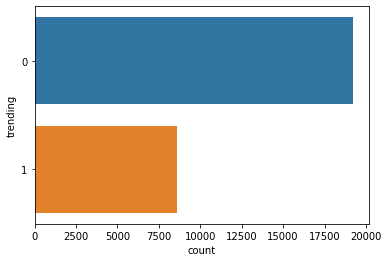

In [22]:
sns.countplot(data=df, y="trending")

In [23]:
fig = px.scatter_3d(df, x='views', y='likes', z='dislikes', color='trending')
fig.show()

In [24]:
fig = px.scatter_3d(df, x='mean_red', y='mean_green', z='mean_blue', color='trending')
fig.show()

#### Zweryfikowanie istotności wybranych atrybutów

In [25]:
X, y = df.drop('trending',1), df['trending']

<AxesSubplot:>

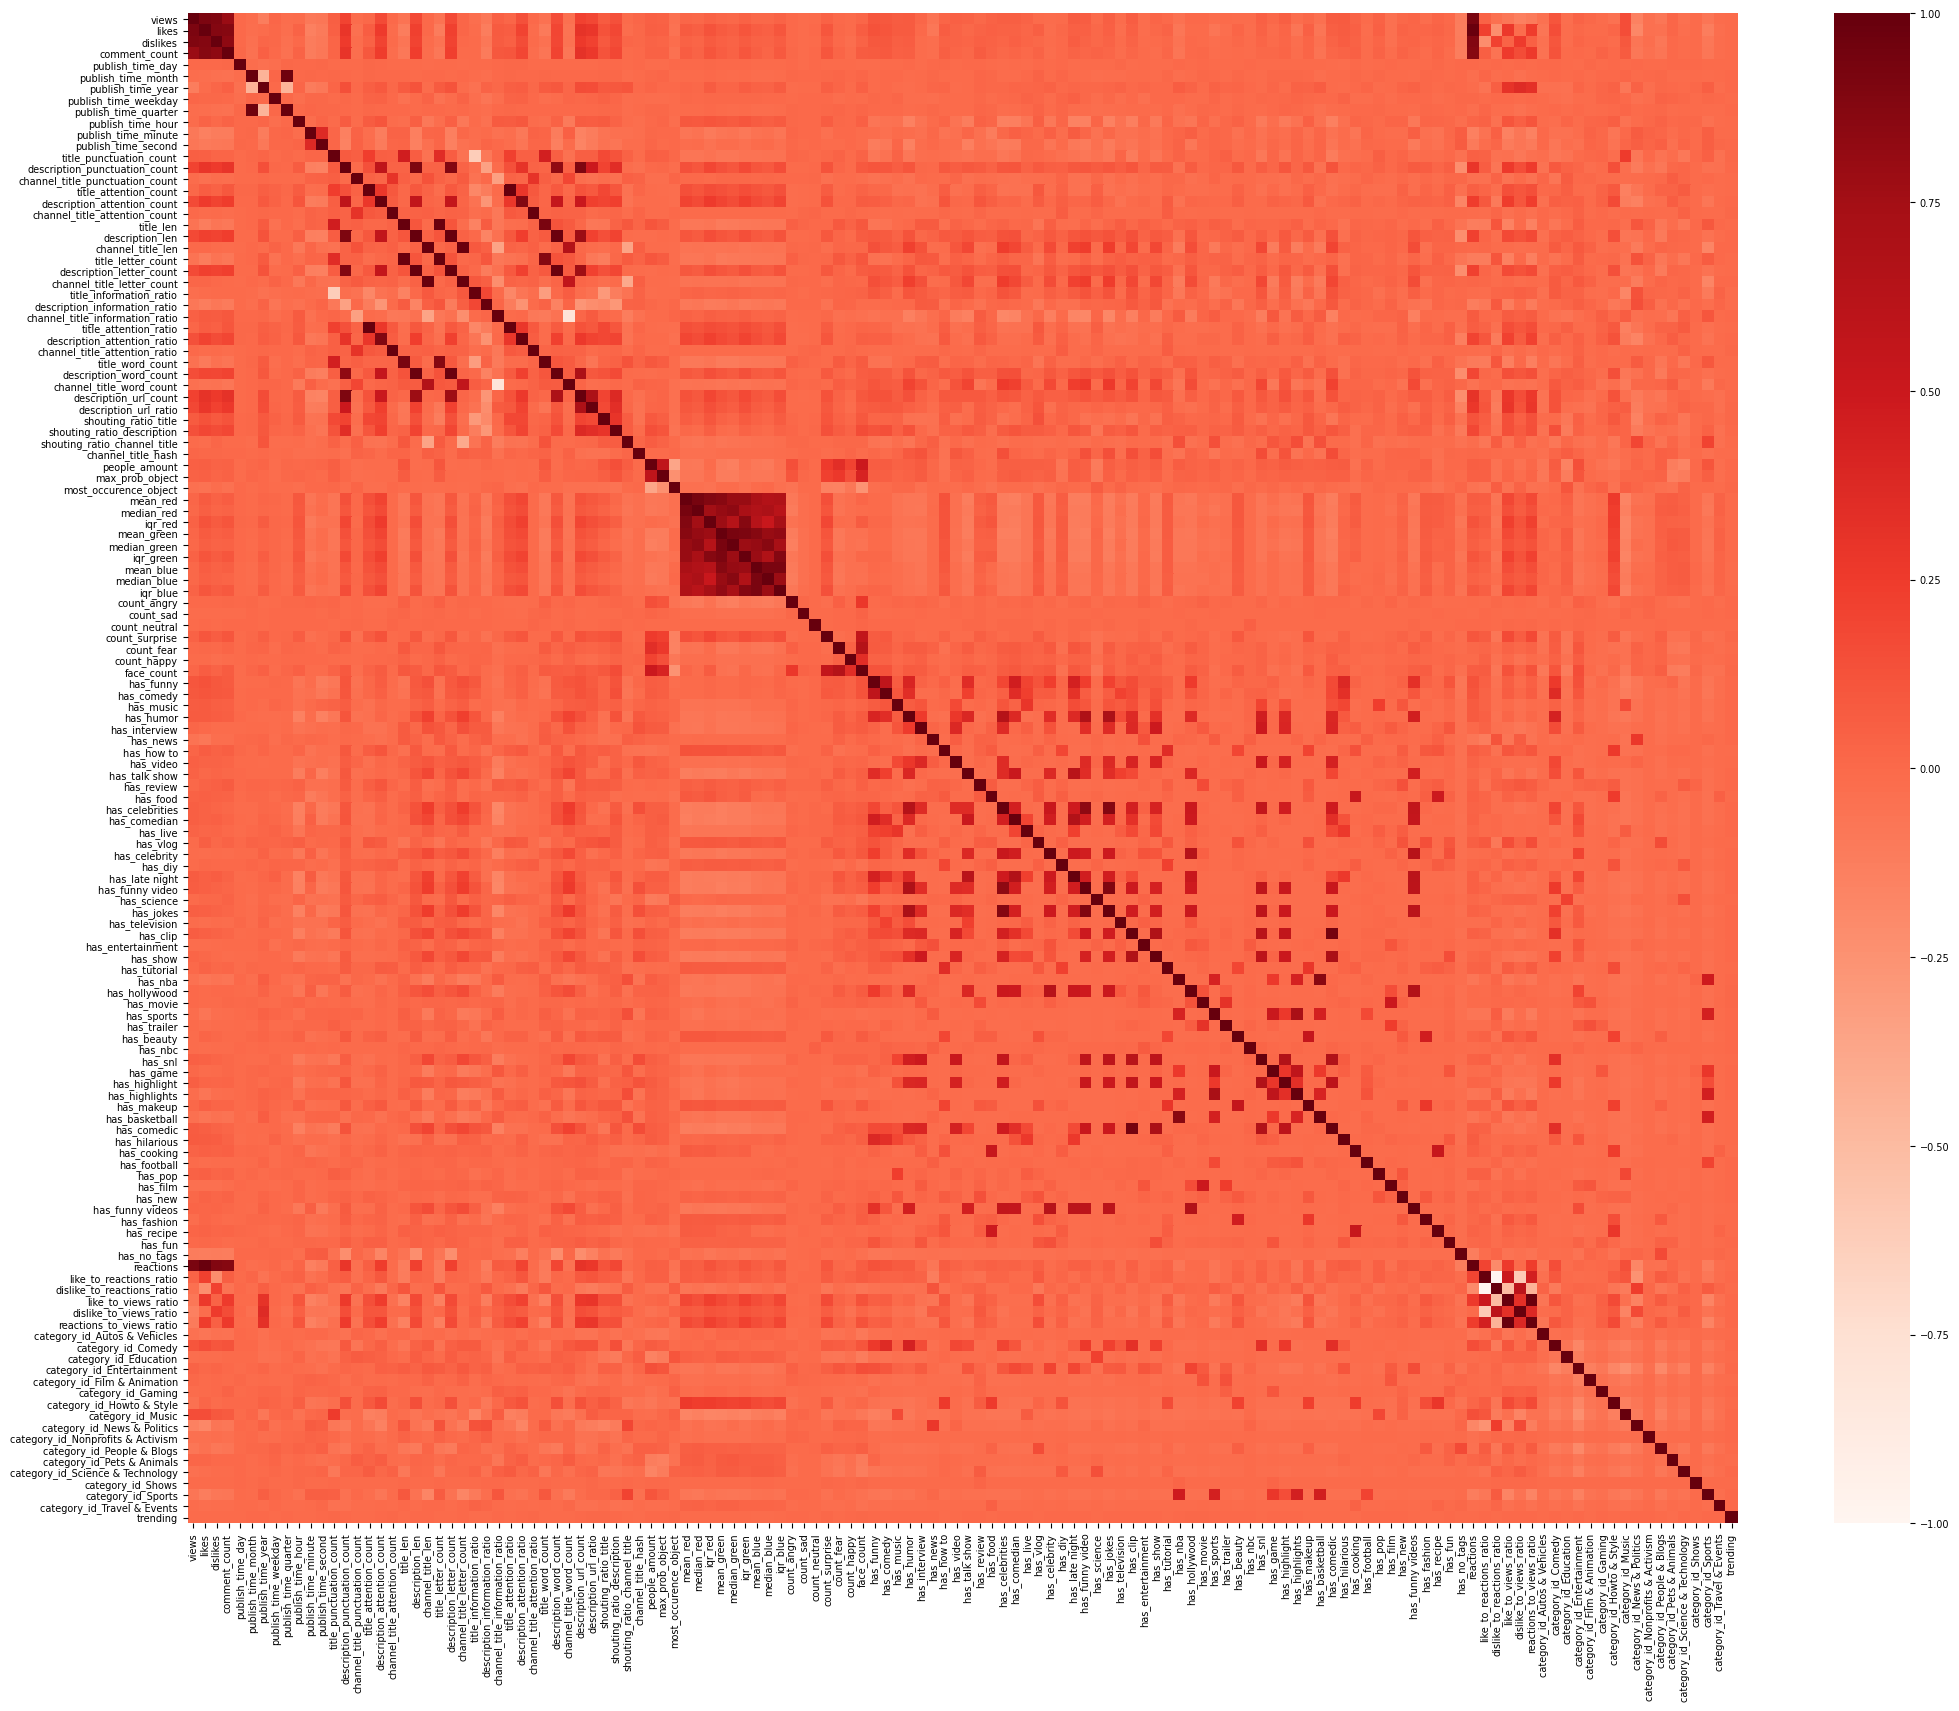

In [26]:
matplotlib.rcParams.update({'font.size': 7})
plt.figure(figsize=(25,20), dpi=100)
cor = df.loc[:, df.columns != 'count_disgust'].corr(method='spearman')
sns.heatmap(cor, cmap=plt.cm.Reds)
# plt.savefig('data/cm.pdf')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


[]

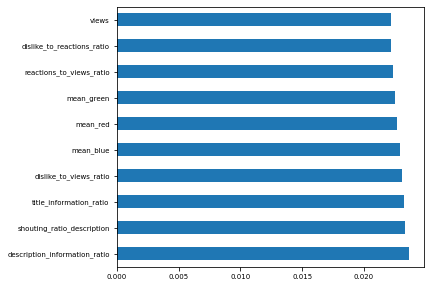

In [27]:
clf = RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)
clf.fit(X, y)
pd.Series(clf.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh')
plt.tight_layout()
plt.grid(False)
plt.plot()

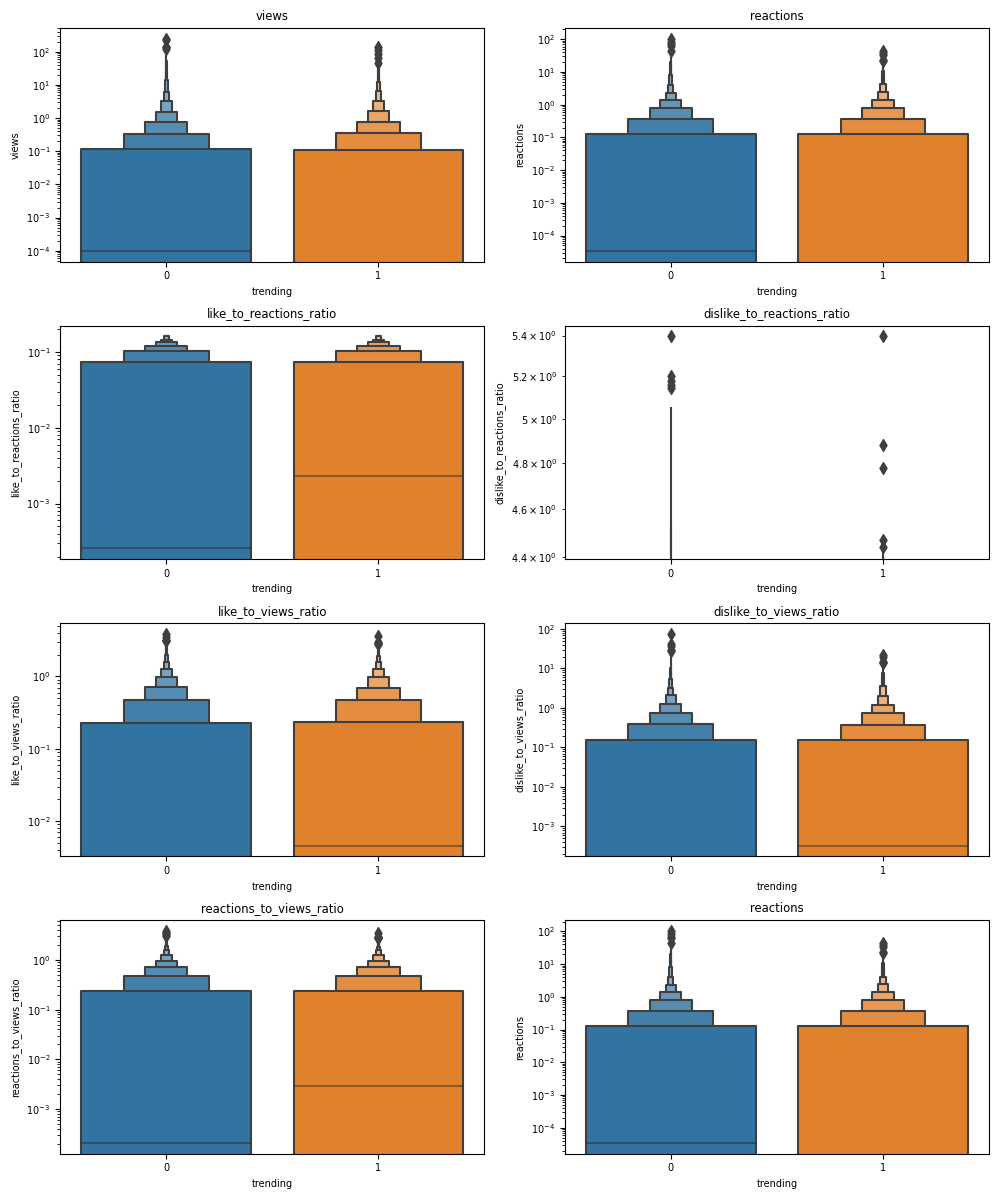

In [28]:
cols = ['views', 'reactions', 'like_to_reactions_ratio', 'dislike_to_reactions_ratio', 'like_to_views_ratio', 'dislike_to_views_ratio', 'reactions_to_views_ratio', 'reactions']

fig, ax = plt.subplots(4 ,2, figsize=(10, 12), dpi=100)
ax = ax.ravel()

for x, col in zip(ax, cols):
    sns.boxenplot(data=df, x='trending', y=col, ax=x)
    x.set(yscale='log', title=col)
    
fig.tight_layout()